### Datasets of Test Vector Leakage Assessment (TVLA) with AES
1. Fixed vs. Random Data with Fixed Key (n traces each)
2. Random vs. Random Data with Fixed Key (2n traces)
3. Fixed vs. Random Key with Random Data (n traces each)
4. Semi-Fixed vs. Random Data with Fixed Key (vary the first 32-bits of the data up to 2^32)

In [1]:
import chipwhisperer as cw
scope = cw.scope()
target = cw.target(scope)
scope.default_setup()

In [2]:
import cwtvla
from cwtvla.ktp import FixedVRandomText #FixedVRandomKey, SemiFixedVRandomText
from tqdm.notebook import trange
import numpy as np

scope.io.tio1 = 'serial_tx'
scope.io.tio2 = 'serial_rx'
scope.trigger.triggers = "nrst"

scope.gain.db = 56
scope.adc.samples = 18000
scope.adc.offset = 24400 + 16000*4
# 1 round: 0
# 2 round: 24400
# 3 round: 24400 + 16000 
# 4 round: 24400 + 16000 + 16000 
# 5 round: 24400 + 16000 + 16000 + 16000 
# 6 round: 24400 + 16000 + 16000 + 16000 + 16000 
scope.adc.decimate = 1
scope.clock.clkgen_freq = 4000000 

cmd=bytearray([255]*1)
ktp = cw.ktp.Basic() 
key_len = 16
ktp = FixedVRandomText(key_len)

In [24]:
traces_enc_groupA = []
text_arrays_groupA = []
key_arrays_groupA = []
traces_enc_groupB = []
text_arrays_groupB = []
key_arrays_groupB = []

In [4]:
N = 100000

In [26]:
#%run "../chipwhisperer-fame/swaes/real_time_plot.ipynb"
#plot = real_time_plot(plot_len=scope.adc.samples-1)

In [27]:
for i in trange(N-len(traces_enc_groupA)):
    scope.arm()
    keyA, textA = ktp.next_group_A()
    target.write(cmd+textA)
    ret = scope.capture()
    if ret:
        print("Target timed out for group A - fixed data!")
        break
    traceA = scope.get_last_trace()
    traces_enc_groupA.append(np.asarray(traceA))
    text_arrays_groupA.append(np.asarray(textA))
    key_arrays_groupA.append(np.asarray(keyA))
    
    scope.arm()
    keyB, textB = ktp.next_group_B()
    target.write(cmd+textB)
    ret = scope.capture()
    if ret:
        print("Target timed out for group B - random data!")
        break
    traceB = scope.get_last_trace()
    traces_enc_groupB.append(np.asarray(traceB))
    text_arrays_groupB.append(np.asarray(textB))
    key_arrays_groupB.append(np.asarray(keyB))

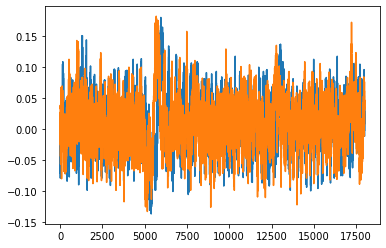

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(traces_enc_groupA[N-1])
plt.plot(traces_enc_groupB[N-1])
plt.show()

### Save 100k fixed enc and pt

In [30]:
np.array(text_arrays_groupA).tofile("text_arrays_groupA_fixed_100k.bin")

In [31]:
traces_enc_groupA_part_1_50k = traces_enc_groupA[0:50000]
traces_enc_groupA_part_2_50k = traces_enc_groupA[50000:100000]

In [32]:
np.array(traces_enc_groupA_part_1_50k).tofile("traces_enc_groupA_part_1_fixed_50k.bin")

In [33]:
np.array(traces_enc_groupA_part_2_50k).tofile("traces_enc_groupA_part_2_fixed_50k.bin")

### Save 100k random enc and pt

In [34]:
np.array(text_arrays_groupB).tofile("text_arrays_groupB_random_100k.bin")

In [35]:
traces_enc_groupB_part_1_50k = traces_enc_groupB[0:50000]
traces_enc_groupB_part_2_50k = traces_enc_groupB[50000:100000]

In [36]:
np.array(traces_enc_groupB_part_1_50k).tofile("traces_enc_groupB_part_1_50k.bin")

In [37]:
np.array(traces_enc_groupB_part_2_50k).tofile("traces_enc_groupB_part_2_50k.bin")

### Another 100k random traces

In [3]:
traces_enc_groupB_2 = []
text_arrays_groupB_2 = []
key_arrays_groupB_2 = []

In [4]:
N = 200000

In [5]:
for i in trange(N-len(traces_enc_groupB_2)):    
    scope.arm()
    keyB, textB = ktp.next_group_B()
    target.write(cmd+textB)
    ret = scope.capture()
    if ret:
        print("Target timed out for group B - random data!")
        break
    traceB = scope.get_last_trace()
    traces_enc_groupB_2.append(np.asarray(traceB))
    text_arrays_groupB_2.append(np.asarray(textB))
    key_arrays_groupB_2.append(np.asarray(keyB))

In [8]:
np.array(text_arrays_groupB_2).tofile("pt_RvR_200k.bin")

In [9]:
a = traces_enc_groupB_2[0:50000]
b = traces_enc_groupB_2[50000:100000]
c = traces_enc_groupB_2[100000:150000]
d = traces_enc_groupB_2[150000:200000]

In [10]:
np.array(a).tofile("t_RvR_200k_1.bin")

In [11]:
np.array(b).tofile("t_RvR_200k_2.bin")

In [12]:
np.array(c).tofile("t_RvR_200k_3.bin")

In [13]:
np.array(d).tofile("t_RvR_200k_4.bin")